<a href="https://colab.research.google.com/github/iljf/NLU_project_team1/blob/main/KLUE_sts_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence-transformers transformers wandb datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import math
import logging
import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split


import torch
from torch.utils.data import DataLoader
from datasets import load_dataset
from sentence_transformers import SentenceTransformer,  LoggingHandler, losses, models, util
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers.readers import InputExample

In [4]:
# device 
def set_device():
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"# available GPUs : {torch.cuda.device_count()}")
        print(f"GPU name : {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
    return device
device = set_device()
device

# available GPUs : 1
GPU name : Tesla T4


device(type='cuda')

In [5]:
# 경로설정
os.chdir('drive/MyDrive/CP2/KLUE_sts_dataset')

In [6]:
# 전처리 확인
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[LoggingHandler()],
)

In [7]:
# klue sts dataset
raw_train_df = pd.read_json('klue-sts-v1.1_train.json')
raw_test_df = pd.read_json('klue-sts-v1.1_dev.json')

In [8]:
labels = raw_train_df.labels.to_list()
labels = pd.DataFrame(labels)

labels2 = raw_test_df.labels.to_list()
labels2 = pd.DataFrame(labels)

In [9]:
raw_train_df = raw_train_df[['sentence1', 'sentence2']].join(labels[['real-label', 'binary-label']])
raw_test_df = raw_test_df[['sentence1', 'sentence2']].join(labels2[['real-label', 'binary-label']])

In [10]:
labels['label'].value_counts()
la1 = len(labels.loc[(labels['label'] >= 0) & (labels['real-label'] < 1.0)])
la2 = len(labels.loc[(labels['label'] >= 1.0) & (labels['real-label'] < 2.0)])
la3 = len(labels.loc[(labels['label'] >= 2.0) & (labels['real-label'] < 3.0)])
la4 = len(labels.loc[(labels['label'] >= 3.0) & (labels['real-label'] < 4.0)])
la5 = len(labels.loc[(labels['label'] >= 4.0) & (labels['real-label'] < 5.0)])

print(f' Score 1미만인 데이터: {la1}\n Score 2미만인 데이터: {la2}\n Score 3미만인 데이터: {la3}\n Score 4미만인 데이터: {la4}\n Score 5미만인 데이터: {la5}')

 Score 1미만인 데이터: 4350
 Score 2미만인 데이터: 906
 Score 3미만인 데이터: 810
 Score 4미만인 데이터: 2852
 Score 5미만인 데이터: 2705


In [ ]:
!git clone https://github.com/kakaobrain/KorNLUDatasets/

In [12]:
path = '/content/drive/MyDrive/CP2/KLUE_sts_dataset/KorNLUDatasets/KorSTS/sts-train.tsv'

In [13]:
raw_train_df2 = pd.read_csv(path, sep="\t+")

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [14]:
raw_train_df2.head()

,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.


In [15]:
raw_train_df2['binary-label'] = raw_train_df2['score'].apply(lambda x: 0 if x < 3  else  1)

In [16]:
raw_train_df2['binary-label'].value_counts()

1    2994
0    2755
Name: binary-label, dtype: int64

In [17]:
raw_train_df2.rename(columns = {'score':'real-label'},inplace=True)

In [18]:
raw_train_df2 = raw_train_df2[['sentence1', 'sentence2',  'real-label', 'binary-label']]
raw_train_df2.head()

,sentence1,sentence2,real-label,binary-label
0,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.,5.00,1
1,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.,3.80,1
2,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.,3.80,1
3,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.,2.60,0
4,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.,4.25,1


In [19]:
raw_train = pd.concat([raw_train_df, raw_train_df2], axis=0, join='inner', ignore_index=True)

In [20]:
raw_train.shape

(17417, 4)

In [22]:
raw_train_df = pd.read_csv('klue-kornlu-sts_train.csv')

In [23]:
# 불용어 처리
import html
import regex as re
from bs4 import BeautifulSoup

def preprocess(sentence):
    sen = BeautifulSoup(html.unescape(sentence), 'html.parser').text     # html parse
    sen = sen.replace("\n", " ")                                    # \n
    sen = re.sub('"',' ', sen)                                      # 따옴표 
    sen = re.sub("[^a-zA-Z0-9가-힣]", " ", sen)                  #영문, 한글, 숫자 만
    sen = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ·!』\\‘〈〉|\(\)\[\]\<\>`\'…》《]','', sen)    
    return sen



def preprocess_train(df):
    sentence1 = df['sentence1'].tolist()
    sentence2 = df['sentence2'].tolist()
    real_label = df['real-label'].tolist()
    label = df['binary-label'].tolist()
    

    processed1 = []
    processed2 = []

    for sen1 in sentence1:
        processed1.append(preprocess(sen1))
    for sen2 in sentence2:
        processed2.append(preprocess(sen2))
    
    processed_df = pd.DataFrame(list(zip(processed1, processed2, real_label, label)),
                        columns = ['sentence1', 'sentence2', 'real_label', 'binary_label'])


    return processed_df

In [24]:
train_df = preprocess_train(raw_train_df)

In [27]:
train_df.head()

,sentence1,sentence2,real_label,binary_label
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3.714286,1
1,위반행위 조사 등을 거부 방해 기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다,0.000000,0
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333,0
3,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업...,고용보험이 1차 고용안전망이라면 국민취업지원제도는 2차 고용안전망입니다,0.571429,0
4,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다,4.714286,1


In [31]:
train_df = train_df.drop_duplicates(['sentence1','sentence2', 'real_label', 'binary_label'], keep='first', ignore_index=True)
test_df = raw_train_df

test_df.rename(columns ={'real-label':'real_label', 'binary-label':'binary_label'}, inplace = True)

In [ ]:
# hanspell 을 통해 sentence1, sentence2 맞춤법 검사
!pip install git+https://github.com/ssut/py-hanspell.git

In [33]:
from hanspell import spell_checker

checked_lst = []
for i in range(len(train_df)):
  checked = spell_checker.check(train_df['sentence1'][i]).as_dict()['checked']
  checked_lst.append(checked)

In [34]:
temp = spell_checker.check(train_df['sentence2'][1308]).as_dict()

In [35]:
checked_lst2 = []
temp_lst = []
for i in range(len(train_df)):
  temp = spell_checker.check(train_df['sentence2'][i]).as_dict()
  checked = temp['checked']
  err = temp['errors']
  checked_lst2.append(checked)
  temp_lst.append(err)

In [36]:
# mean 0.45 error fixed
np.mean(temp_lst)

0.4562514390973981

In [39]:
train_df['spell_checked1'] = checked_lst
train_df['spell_checked2'] = checked_lst2
train_df.head()

,sentence1,sentence2,real_label,binary_label,spell_checked1,spell_checked2
0,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다,3.714286,1,숙소 위치는 찾기 쉽고 일반적인 한국의 반지하 숙소입니다,숙박시설의 위치는 쉽게 찾을 수 있고 한국의 대표적인 반지하 숙박시설입니다
1,위반행위 조사 등을 거부 방해 기피한 자는 500만원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산 뿐만이 아니었다,0.000000,0,위반행위 조사 등을 거부 방해 기피한 자는 500만 원 이하 과태료 부과 대상이다,시민들 스스로 자발적인 예방 노력을 한 것은 아산뿐만이 아니었다
2,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘,0.333333,0,회사가 보낸 메일은 이 지메일이 아니라 다른 지메일 계정으로 전달해줘,사람들이 주로 네이버 메일을 쓰는 이유를 알려줘
3,긴급 고용안정지원금은 지역고용대응 등 특별지원금 지자체별 소상공인 지원사업 취업...,고용보험이 1차 고용안전망이라면 국민취업지원제도는 2차 고용안전망입니다,0.571429,0,긴급 고용안정 지원금은 지역 고용 대응 등 특별 지원금 지자체별 소상공인 지원 사...,고용보험이 1차 고용안전망이라면 국민 취업지원 제도는 2차 고용안전망입니다
4,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다,4.714286,1,호스트의 답장이 늦으나 개선될 것으로 보입니다,호스트 응답이 늦었지만 개선될 것으로 보입니다


In [40]:
train_df[['sentence1','sentence2','real_label','binary_label']].to_csv('klue_sts_train_aug.csv', index=False)

In [44]:
train_aug = pd.read_csv('klue_sts_train_aug.csv')

In [46]:
train, val = train_test_split((train_aug), test_size=0.1, random_state = 42)

In [48]:
train_data = train.reset_index().drop(['index'], axis = 1)
valid_data = val.reset_index().drop(['index'], axis = 1)
test_data = test_df.reset_index().drop(['index'], axis = 1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


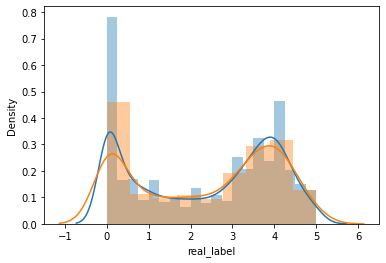

In [49]:
sns.distplot(train_data['real_label'])
sns.distplot(valid_data['real_label'])

In [50]:
sum_train = pd.concat([train_data, valid_data])

In [51]:
from sentence_transformers.readers import InputExample
# sentence_trainsforemrs 패키지의 입력 형태 InputExample(texts, label)
gold_samples = []
test_samples = []

for sentence1, sentence2, score in zip(sum_train['sentence1'], sum_train['sentence2'], sum_train['real_label']):

  score = float(score) / 5.0 # 유사도 측정을 위해 scaling
  
  inp_example = InputExample(
      texts = [sentence1, sentence2],
      label = score,
  )
  rev_inp_example = InputExample(       #유사도 측정으로 샘플링 되기 때문에 순서를 바꿔서도 입력
      texts = [sentence2, sentence1],
      label = score)
  
  gold_samples.append(inp_example)
  gold_samples.append(rev_inp_example)


for sentence1, sentence2, score in zip(test_data['sentence1'], test_data['sentence2'], test_data['real_label']):

  score = float(score) / 5.0
  
  inp_example = InputExample(
      texts = [sentence1, sentence2],
      label = score,
  )
  rev_inp_example = InputExample(
      texts = [sentence2, sentence1],
      label = score)
  
  test_samples.append(inp_example)
  test_samples.append(rev_inp_example)

In [52]:
unique_sentences = set()
silver_data = []

for sample in gold_samples:
    unique_sentences.update(sample.texts)

print(len(unique_sentences))

33673


In [53]:
unique_sentences = list(unique_sentences)
sent2idx = {sentence: idx for idx, sentence in enumerate(unique_sentences)}
duplicates = set((sent2idx[data.texts[0]], sent2idx[data.texts[1]]) for data in gold_samples)

In [54]:
# 4 epochs, train_batch
semantic_search_model = SentenceTransformer("Huffon/sentence-klue-roberta-base")
# 유니크 데이터 임베딩
embeddings = semantic_search_model.encode(unique_sentences, batch_size = 128, convert_to_tensor=True)

2022-06-01 09:03:26 - Load pretrained SentenceTransformer: Huffon/sentence-klue-roberta-base


Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.91k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

2022-06-01 09:03:43 - No sentence-transformers model found with name /root/.cache/torch/sentence_transformers/Huffon_sentence-klue-roberta-base. Creating a new one with MEAN pooling.
2022-06-01 09:03:44 - Use pytorch device: cuda


Batches:   0%|          | 0/264 [00:00<?, ?it/s]

In [55]:
top_k = 3
# cos_sim 기준 top 3 문장 조합을 추가 데이터로 활용
progress = tqdm.tqdm(unit="docs", total=len(sent2idx))
for idx in range(len(unique_sentences)):
    sentence_embedding = embeddings[idx]              
    cos_scores = util.cos_sim(sentence_embedding, embeddings)[0]  #인덱스를 바꿔가면서 모든 문장과 비교
    cos_scores = cos_scores.cpu()
    progress.update(1)

    #We use torch.topk to find the highest 3 scores
    top_results = torch.topk(cos_scores, k=top_k+1) #Top 3 문장 추출
    
    for score, iid in zip(top_results[0], top_results[1]):
        if iid != idx and (iid, idx) not in duplicates:
            silver_data.append((unique_sentences[idx], unique_sentences[iid]))
            duplicates.add((idx,iid))

progress.reset()
progress.close()

  0%|          | 0/33673 [00:00<?, ?docs/s]


In [58]:
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CECorrelationEvaluator
# cross_encoder 훈련 세팅
cross_encoder = CrossEncoder("klue/roberta-base", num_labels=1)
train_batch_size = 16
num_epochs = 4
max_seq_length = 128

# Train Dataloader 생성
train_dataloader = DataLoader(gold_samples, shuffle=True, batch_size=16)
# Test data로 성능 지표 확인
evaluator = CECorrelationEvaluator.from_input_examples(test_samples, name='sts-test')

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
print(warmup_steps)

Some weights of the model checkpoint at klue/roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at klue/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classif

2022-06-01 09:07:25 - Use pytorch device: cuda
869


In [59]:
cross_encoder.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          warmup_steps=warmup_steps)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2172 [00:00<?, ?it/s]

2022-06-01 09:15:54 - CECorrelationEvaluator: Evaluating the model on sts-test dataset after epoch 0:
2022-06-01 09:18:21 - Correlation:	Pearson: 0.9692	Spearman: 0.9481


Iteration:   0%|          | 0/2172 [00:00<?, ?it/s]

2022-06-01 09:26:35 - CECorrelationEvaluator: Evaluating the model on sts-test dataset after epoch 1:
2022-06-01 09:29:03 - Correlation:	Pearson: 0.9842	Spearman: 0.9716


Iteration:   0%|          | 0/2172 [00:00<?, ?it/s]

2022-06-01 09:37:17 - CECorrelationEvaluator: Evaluating the model on sts-test dataset after epoch 2:
2022-06-01 09:39:45 - Correlation:	Pearson: 0.9897	Spearman: 0.9801


Iteration:   0%|          | 0/2172 [00:00<?, ?it/s]

2022-06-01 09:47:59 - CECorrelationEvaluator: Evaluating the model on sts-test dataset after epoch 3:
2022-06-01 09:50:27 - Correlation:	Pearson: 0.9925	Spearman: 0.9848


In [60]:
silver_scores = cross_encoder.predict(silver_data)
# All model predictions should be between [0,1]
assert all(0.0 <= score <= 1.0 for score in silver_scores)

Batches:   0%|          | 0/3157 [00:00<?, ?it/s]

In [62]:
silver_sentence1, silver_sentence2 = zip(*silver_data)

In [63]:
silver_data = pd.DataFrame({
    "sentence1" : silver_sentence1,
    "sentence2" : silver_sentence2,
    "real_label" : silver_scores * 5.0}
)

In [64]:
silver_data

,sentence1,sentence2,real_label
0,버스는 적어도 10분에 한 대씩 오는 편이었습니다,버스는 적어도 10분에 한 번은 오곤 했습니다,4.397765
1,버스는 적어도 10분에 한 대씩 오는 편이었습니다,그래도 버스를 이용하면 좋을 거리예요,1.241600
2,버스는 적어도 10분에 한 대씩 오는 편이었습니다,그래서 저는 주로 버스를 이용했습니다,1.639827
3,수잔 G 코멘 유턴 계획된 부모 기금 삭감,코멘은 계획된 부모 기금을 삭감하지 않을 것이다,2.311583
4,수잔 G 코멘 유턴 계획된 부모 기금 삭감,히딕 로샨 아내 수잔느의 일부 방법,1.149009
...,...,...,...
101014,집이 거실 하나 복층 하나 방하나 해서 총 여섯명이 묵기에는 충분합니다,거실에 하나 방에 하나 총 두개가 있었습니다,1.629375
101015,집이 거실 하나 복층 하나 방하나 해서 총 여섯명이 묵기에는 충분합니다,방 5개 욕실3개 주방및 거실공간도 충분합니다,1.198613
101016,이스라엘 바스 독일 작가 잔디 시,이스라엘은 독일 작가 풀이 시를 방문하는 것을 막는다,4.683424
101017,이스라엘 바스 독일 작가 잔디 시,팔레스타인의 기아 공격수 이스라엘 리치,1.583332


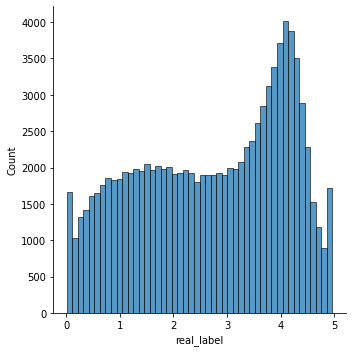

In [65]:
sns.displot(silver_data['real_label'])

In [66]:
def make_balance(x):
  """
  그래프 상의 x축을 기준으로 A, B, C, Z 섹션을 나눠주기 위한 함수
  섹션을 나눠준 기준 : 그래프상에서 가장 undersampling이 필요한 부분을 임의로 나눠줌
  Z섹션은 undersampling이 필요하지 않다고 판단한 부분
  """
  if x <= 3:
    return 'Z' 

  elif (x > 3) & (x < 3.5):
    return 'A'

  elif (x >= 3.5) & (x < 3.8):
    return 'B'

  elif (x >= 3.8) & (x < 4.6):
    return 'C'
  else:
    return 'Z'

In [67]:
silver_data['drop_label'] = silver_data['real_label'].apply(make_balance)

In [68]:
silver_shuffled = silver_data.sample(frac=1).reset_index(drop=True)

In [76]:
indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 3.5 ][:2500].index  
silver_shuffled.drop(indexNames , inplace=True)

indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 3.8 ][:40000].index
silver_shuffled.drop(indexNames , inplace=True)

indexNames = silver_shuffled[ silver_shuffled['drop_label'] == 4.75 ][:30000].index
silver_shuffled.drop(indexNames , inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


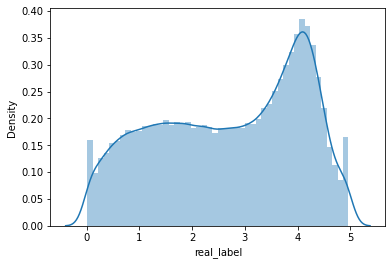

In [77]:
sns.distplot(silver_shuffled['real_label'])

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


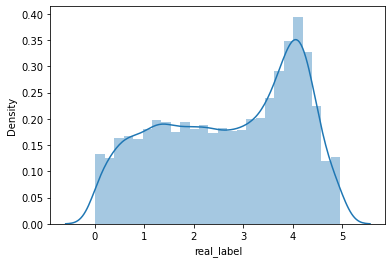

In [78]:
sampled_df = silver_shuffled.sample(n=15000, random_state=17)
# 아까 만든 drop_label 컬럼 삭제
sampled_df = sampled_df.drop('drop_label', axis=1)

# 마지막으로 distplot 확인
sns.distplot(sampled_df['real_label'])

In [79]:
sampled_df

,sentence1,sentence2,real_label
32619,어떤 여성이 다른 개들이 그들을 따라가면서 애완견과 함께 열린 땅 위를 걷고 있다,한 여성이 개와 함께 걷고 있다,3.164136
18965,비엔나에 있는 이 아파트는 잊을 수 없는 것이었습니다,비엔나 머무신다면 꼭 이 숙소 머무시길 강추합니다,1.908493
51332,메일을 보낸 사람이 수강생인건 지우지 마세요,수강생이 보낸 메일은 절대 지워서 안됩니다,4.076117
75045,롬니가 선거에서 승리할 경우 대법원의 가능성,오바마는 토론에서 롬니에 대해 공격한다,0.720102
40644,선로에서 유휴 중인 검은 열차,대부분 검은 열차가 선로에 있다,2.913129
...,...,...,...
52528,일주일에 한 번 이상 홍보 메일을 보내는 저널 목록 알려줘,홍보 메일을 일주일에 한 번 이상 보내는 저널 리스트 알려줘,4.526291
48581,기니 투표가 장기간 지연된 입법 여론조사에서,입법 여론조사에서 에콰토구아인 투표,3.590003
2968,방 3개에 각 게스트가 숙박하고 화장실과 부엌은 공용입니다,한 집에 방은 3개 있고 화장실과 샤워실은 공동 사용입니다,3.497836
7560,언제 에어컨 작동하도록 예약해놨어,에어컨 작동 예약해놓은 시간 알려줘,4.191864


In [80]:
aug_train_data = pd.concat([train_data, valid_data]).reset_index().drop(['index'], axis = 1)
aug_train_data

,sentence1,sentence2,real_label,binary_label
0,동남권 메가시티 외에 경남형 지역뉴딜 사업 계획과 방향 이에 임하는 각오나 포부를...,향후에는 그린 뉴딜 디지털 뉴딜 등 한국형 뉴딜 사업과 같은 국정기조와 규제자유특...,0.142857,0
1,푸틴 대통령은 러시아가 대책을 취할 것이라고 말했다,푸틴은 러시아가 보복조치를 취할 것이라고 경고했다,4.400000,1
2,오후 6시에 길바닥에 나 앉으실수도 있으니까요,안에 여행정보 담긴 지도나 책도 있어요,0.000000,0
3,이집트 군대가 납치범들을 공격하도록 강요하다,이집트의 모르시는 인질 비디오가 등장함에 따라 회담을 배제한다,1.400000,0
4,코로나19 확산으로 인해 취소됐던 사업별 오프라인 설명회는 유튜브 등 온라인으로 실...,먼저 공공부문 직접일자리 94만5000개 가운데 그동안 코로나19로 정상 추진되지 ...,0.500000,0
...,...,...,...,...
17367,더위와 추위 중 싫어하는 것을 골라주세요,비 올 때 빨래하지마,0.000000,0
17368,평일에도 특히 브로드웨이 마켓이 열리는 주말에는 런더너가 된 기분을 느끼실 수 ...,평일엔 특히 브로드웨이 시장이 열리는 주말에는 2위라고 느낄 수 있습니다,2.666667,0
17369,일반 화장품 말고 땡볕에는 선크림 바르도록 해,땡볕에는 비비크림 말고 선크림 바르게,3.428571,1
17370,다음에 대만 방문할일 있으면 꼭 이 호스트한테서 또 예약할거예요,프라하에 돌아간다면 꼭 다시 선택할거예요,0.000000,0


In [81]:
aug_valid_data = sampled_df.reset_index().drop(['index'], axis = 1)
aug_valid_data

,sentence1,sentence2,real_label
0,어떤 여성이 다른 개들이 그들을 따라가면서 애완견과 함께 열린 땅 위를 걷고 있다,한 여성이 개와 함께 걷고 있다,3.164136
1,비엔나에 있는 이 아파트는 잊을 수 없는 것이었습니다,비엔나 머무신다면 꼭 이 숙소 머무시길 강추합니다,1.908493
2,메일을 보낸 사람이 수강생인건 지우지 마세요,수강생이 보낸 메일은 절대 지워서 안됩니다,4.076117
3,롬니가 선거에서 승리할 경우 대법원의 가능성,오바마는 토론에서 롬니에 대해 공격한다,0.720102
4,선로에서 유휴 중인 검은 열차,대부분 검은 열차가 선로에 있다,2.913129
...,...,...,...
14995,일주일에 한 번 이상 홍보 메일을 보내는 저널 목록 알려줘,홍보 메일을 일주일에 한 번 이상 보내는 저널 리스트 알려줘,4.526291
14996,기니 투표가 장기간 지연된 입법 여론조사에서,입법 여론조사에서 에콰토구아인 투표,3.590003
14997,방 3개에 각 게스트가 숙박하고 화장실과 부엌은 공용입니다,한 집에 방은 3개 있고 화장실과 샤워실은 공동 사용입니다,3.497836
14998,언제 에어컨 작동하도록 예약해놨어,에어컨 작동 예약해놓은 시간 알려줘,4.191864


In [82]:
aug_train_data.to_csv('aug_klue_sts_train.csv', index=False)
aug_valid_data.to_csv('aug_klue_sts_vaild.csv', index=False)